# 1. Data Loading and k-NN Theory

## Overview
This notebook covers:
- Loading and exploring the Banknote Authentication dataset
- Understanding k-Nearest Neighbors (k-NN) algorithm
- Lazy learning concepts
- Distance metrics theory
- Data preparation for k-NN

## What is k-Nearest Neighbors?

k-NN is a **lazy learning** algorithm that:
- Stores all training data during the "training" phase
- Makes predictions based on the k closest training examples
- Uses majority voting for classification
- Defers computation until prediction time

### Lazy Learning vs Eager Learning

**Eager Learning (e.g., Decision Trees, SVM):**
```
Training Phase: Data → Build Model → Store Model
Prediction: New Instance → Apply Model → Prediction
```

**Lazy Learning (k-NN):**
```
Training Phase: Data → Store All Instances
Prediction: New Instance → Find k Neighbors → Vote → Prediction
```

### Key Characteristics
- **No explicit model building** - Fast training, slow prediction
- **Instance-based** - Uses stored training examples
- **Non-parametric** - No assumptions about data distribution
- **Distance-based** - Relies on distance metrics

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Dataset: Banknote Authentication

This dataset contains features extracted from images of genuine and forged banknotes.

**Features:**
- **Variance** of Wavelet Transformed image
- **Skewness** of Wavelet Transformed image  
- **Curtosis** of Wavelet Transformed image
- **Entropy** of image

**Target:**
- **Class**: 0 = Genuine, 1 = Forged

This is a perfect dataset for k-NN because:
- Clear binary classification problem
- Continuous numerical features
- Well-separated classes based on image characteristics

In [2]:
# Load the banknote authentication dataset
data_path = '../data/banknote_authentication.csv'
df = pd.read_csv(data_path)

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset loaded successfully!
Shape: (1372, 5)

First 5 rows:


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
# Explore dataset characteristics
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Total samples: {len(df)}")
print(f"Features: {list(df.columns[:-1])}")
print(f"Target variable: {df.columns[-1]}")

print("\nCLASS DISTRIBUTION:")
class_counts = df['class'].value_counts().sort_index()
print(f"Genuine banknotes (0): {class_counts[0]} ({class_counts[0]/len(df)*100:.1f}%)")
print(f"Forged banknotes (1): {class_counts[1]} ({class_counts[1]/len(df)*100:.1f}%)")

print("\nMISSING VALUES:")
print(df.isnull().sum())

print("\nFEATURE STATISTICS:")
df.describe()

DATASET OVERVIEW
Total samples: 1372
Features: ['variance', 'skewness', 'curtosis', 'entropy']
Target variable: class

CLASS DISTRIBUTION:
Genuine banknotes (0): 762 (55.5%)
Forged banknotes (1): 610 (44.5%)

MISSING VALUES:
variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

FEATURE STATISTICS:


,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


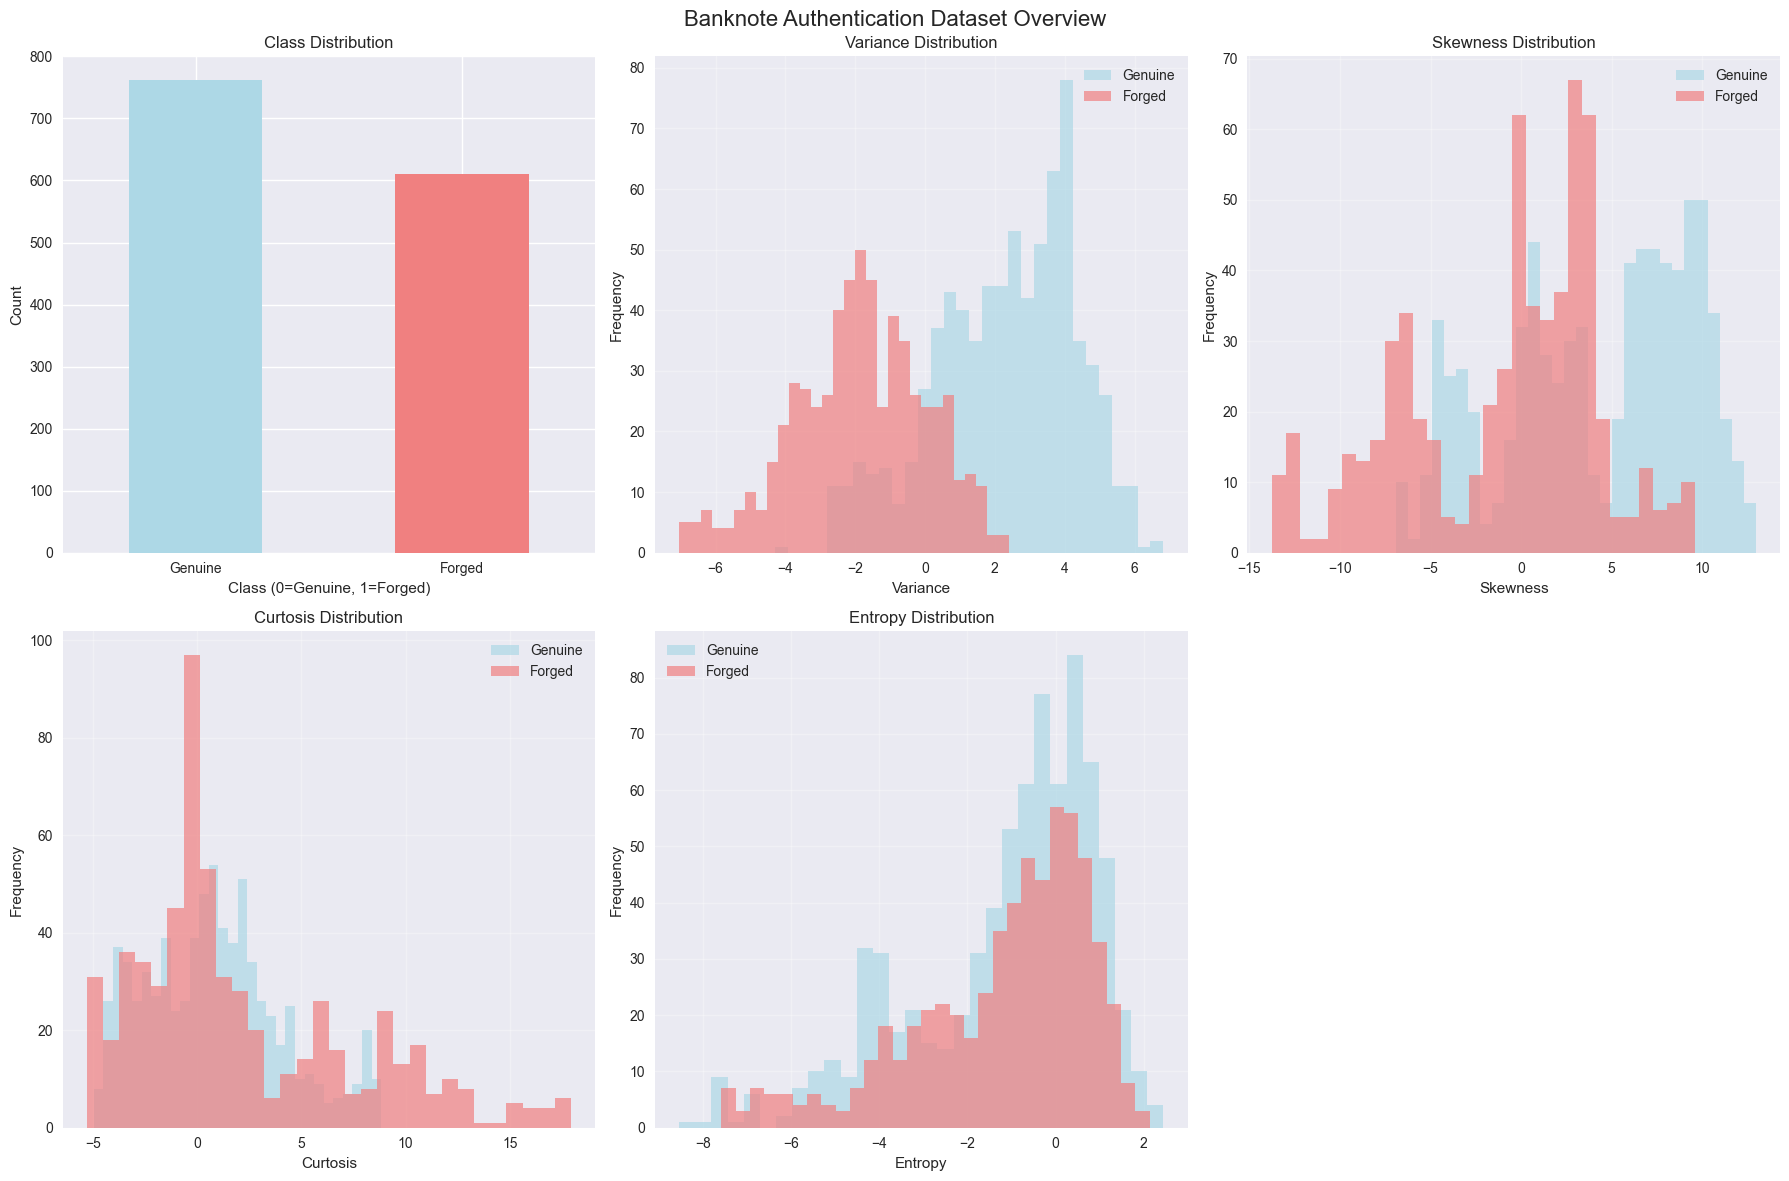

In [4]:
# Visualize dataset characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Banknote Authentication Dataset Overview', fontsize=16)

# Class distribution
class_counts.plot(kind='bar', ax=axes[0,0], color=['lightblue', 'lightcoral'])
axes[0,0].set_title('Class Distribution')
axes[0,0].set_xlabel('Class (0=Genuine, 1=Forged)')
axes[0,0].set_ylabel('Count')
axes[0,0].set_xticklabels(['Genuine', 'Forged'], rotation=0)

# Feature distributions
features = ['variance', 'skewness', 'curtosis', 'entropy']
for i, feature in enumerate(features):
    row = (i + 1) // 3
    col = (i + 1) % 3
    
    # Histogram by class
    for class_val in [0, 1]:
        data_subset = df[df['class'] == class_val][feature]
        label = 'Genuine' if class_val == 0 else 'Forged'
        color = 'lightblue' if class_val == 0 else 'lightcoral'
        axes[row, col].hist(data_subset, bins=30, alpha=0.7, label=label, color=color)
    
    axes[row, col].set_title(f'{feature.capitalize()} Distribution')
    axes[row, col].set_xlabel(feature.capitalize())
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

## Distance Metrics Theory

k-NN relies on distance metrics to find the "nearest" neighbors. The choice of distance metric significantly affects performance.

### 1. Euclidean Distance (L₂ Norm)
```
d(x,y) = √(Σᵢ(xᵢ - yᵢ)²)
```
- **Use Case:** Continuous features, circular decision boundaries
- **Properties:** Sensitive to outliers, assumes equal feature importance

### 2. Manhattan Distance (L₁ Norm)
```
d(x,y) = Σᵢ|xᵢ - yᵢ|
```
- **Use Case:** High-dimensional data, robust to outliers
- **Properties:** Creates diamond-shaped decision boundaries

### 3. Cosine Distance
```
d(x,y) = 1 - (x·y)/(||x||·||y||)
```
- **Use Case:** Text data, high-dimensional sparse vectors
- **Properties:** Measures angle rather than magnitude

DISTANCE CALCULATION EXAMPLE
Point A (Genuine): [ 3.6216   8.6661  -2.8073  -0.44699]
Point B (Forged):  [-1.3971  3.3191 -1.3927 -1.9948]

Euclidean Distance: 7.6272
Manhattan Distance: 13.3281
Cosine Distance:    0.3316


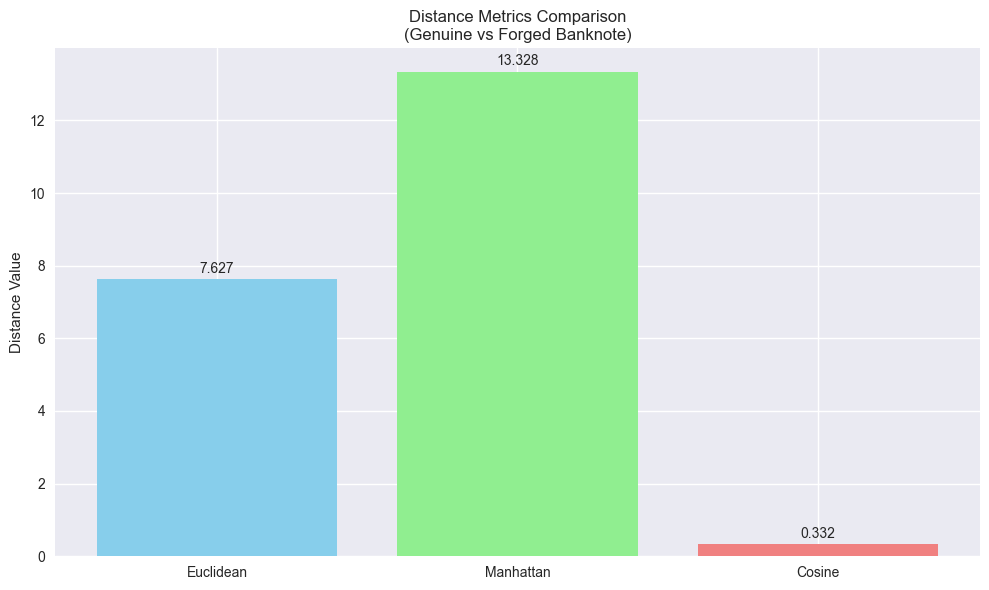

In [5]:
# Demonstrate distance calculations with sample points
# Take two sample points from the dataset
point_a = df.iloc[0, :-1].values  # First genuine banknote
point_b = df.iloc[762, :-1].values  # First forged banknote

print("DISTANCE CALCULATION EXAMPLE")
print("=" * 40)
print(f"Point A (Genuine): {point_a}")
print(f"Point B (Forged):  {point_b}")

# Calculate different distances
euclidean_dist = np.sqrt(np.sum((point_a - point_b)**2))
manhattan_dist = np.sum(np.abs(point_a - point_b))
cosine_dist = 1 - np.dot(point_a, point_b) / (np.linalg.norm(point_a) * np.linalg.norm(point_b))

print(f"\nEuclidean Distance: {euclidean_dist:.4f}")
print(f"Manhattan Distance: {manhattan_dist:.4f}")
print(f"Cosine Distance:    {cosine_dist:.4f}")

# Visualize the difference
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
distances = [euclidean_dist, manhattan_dist, cosine_dist]
metric_names = ['Euclidean', 'Manhattan', 'Cosine']
colors = ['skyblue', 'lightgreen', 'lightcoral']

bars = ax.bar(metric_names, distances, color=colors)
ax.set_title('Distance Metrics Comparison\n(Genuine vs Forged Banknote)')
ax.set_ylabel('Distance Value')

# Add value labels on bars
for bar, dist in zip(bars, distances):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{dist:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Data Preparation for k-NN

### Why Feature Scaling is Critical for k-NN

k-NN is **distance-based**, so features with larger scales will dominate the distance calculation.

**Example:**
- Feature A: Range 0-1
- Feature B: Range 0-1000
- Distance will be dominated by Feature B!

**Solution:** Standardization (Z-score normalization)
```
x_scaled = (x - μ) / σ
```

In [6]:
# Prepare data for k-NN
print("DATA PREPARATION FOR k-NN")
print("=" * 30)

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distribution in splits
print("\nClass distribution in training set:")
print(y_train.value_counts().sort_index())
print("\nClass distribution in test set:")
print(y_test.value_counts().sort_index())

DATA PREPARATION FOR k-NN
Features shape: (1372, 4)
Target shape: (1372,)

Training set: 960 samples
Test set: 412 samples

Class distribution in training set:
class
0    533
1    427
Name: count, dtype: int64

Class distribution in test set:
class
0    229
1    183
Name: count, dtype: int64


In [7]:
# Feature scaling demonstration
print("BEFORE SCALING:")
print("Feature ranges:")
for col in X.columns:
    print(f"{col}: [{X[col].min():.2f}, {X[col].max():.2f}]")

# Apply standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for visualization
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\nAFTER SCALING:")
print("Feature ranges:")
for col in X_train_scaled_df.columns:
    print(f"{col}: [{X_train_scaled_df[col].min():.2f}, {X_train_scaled_df[col].max():.2f}]")

print("\nScaled features have mean ≈ 0 and std ≈ 1")
print("Training set means:", X_train_scaled_df.mean().round(3).values)
print("Training set stds:", X_train_scaled_df.std().round(3).values)

BEFORE SCALING:
Feature ranges:
variance: [-7.04, 6.82]
skewness: [-13.77, 12.95]
curtosis: [-5.29, 17.93]
entropy: [-8.55, 2.45]

AFTER SCALING:
Feature ranges:
variance: [-2.65, 2.22]
skewness: [-2.67, 1.89]
curtosis: [-1.51, 3.79]
entropy: [-3.51, 1.59]

Scaled features have mean ≈ 0 and std ≈ 1
Training set means: [ 0. -0.  0. -0.]
Training set stds: [1.001 1.001 1.001 1.001]


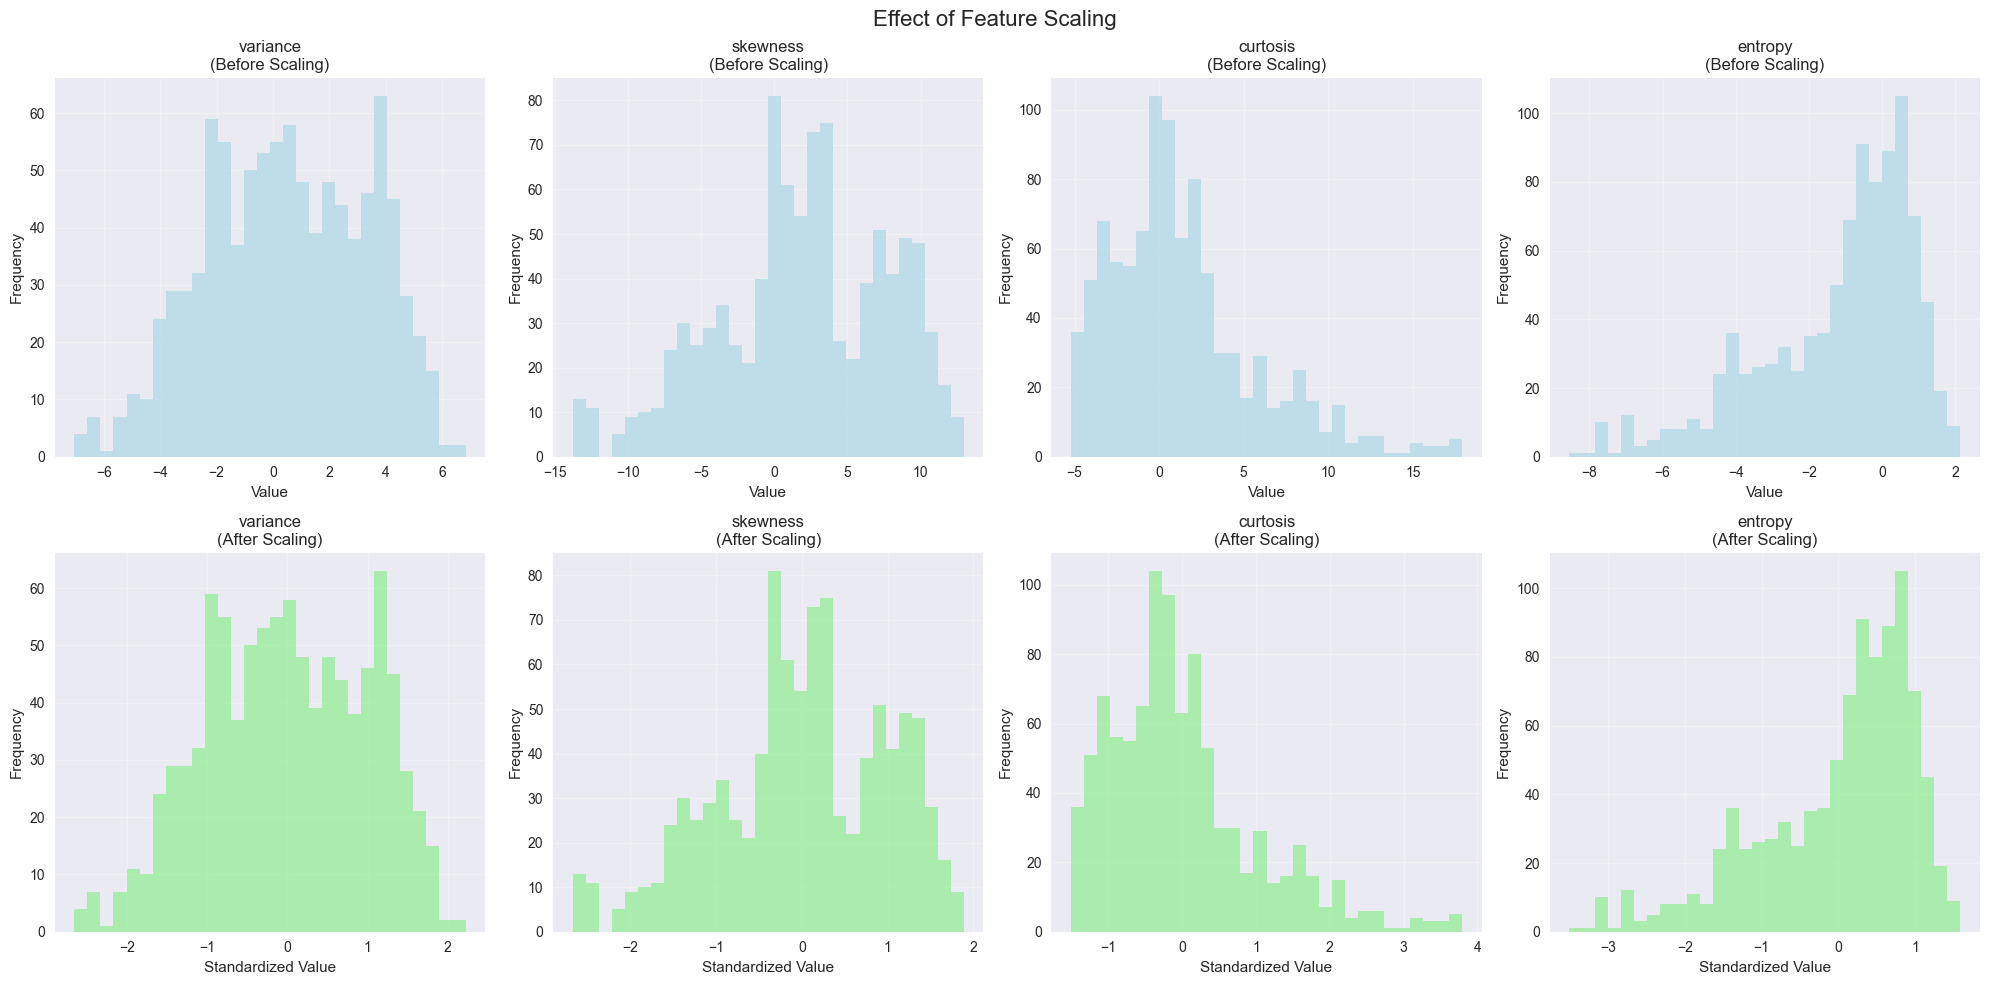

In [8]:
# Visualize the effect of scaling
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Effect of Feature Scaling', fontsize=16)

features = X.columns

# Before scaling
for i, feature in enumerate(features):
    X_train[feature].hist(bins=30, ax=axes[0, i], alpha=0.7, color='lightblue')
    axes[0, i].set_title(f'{feature}\n(Before Scaling)')
    axes[0, i].set_xlabel('Value')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].grid(True, alpha=0.3)

# After scaling
for i, feature in enumerate(features):
    X_train_scaled_df[feature].hist(bins=30, ax=axes[1, i], alpha=0.7, color='lightgreen')
    axes[1, i].set_title(f'{feature}\n(After Scaling)')
    axes[1, i].set_xlabel('Standardized Value')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

### What We Learned:

1. **k-NN is a Lazy Learning Algorithm**
   - Stores all training data
   - No explicit model building
   - Computation happens at prediction time

2. **Distance Metrics are Critical**
   - Euclidean: Most common, sensitive to outliers
   - Manhattan: Robust to outliers
   - Cosine: Good for high-dimensional data

3. **Feature Scaling is Essential**
   - k-NN is distance-based
   - Features with larger scales dominate
   - Standardization ensures equal feature importance

4. **Banknote Dataset Characteristics**
   - 1,372 samples with 4 features
   - Binary classification (genuine vs forged)
   - Well-balanced classes
   - Clear feature separability

### Next Steps:
In the next notebook, we'll implement the k-NN algorithm and see how lazy learning works in practice!

In [10]:
# Save prepared data for next notebooks
import pickle

# Save the prepared data
data_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'scaler': scaler,
    'feature_names': list(X.columns)
}

with open('../data/prepared_banknote_data.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

print("Prepared data saved for next notebooks!")
print("\nReady for training in the next notebook! 🚀")

Prepared data saved for next notebooks!

Ready for training in the next notebook! 🚀
